# Speech Recognition with Pytorch

Link: https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

In [2]:
# %matplotlib inline 

import os 
import torch 
import torchaudio 
import requests
import matplotlib
import matplotlib.pyplot as plt 
import IPython

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs('_assets', exist_ok=True)
    with open(SPEECH_FILE, 'wb') as file:
        file.write(requests.get(SPEECH_FILE).content)

1.10.2
0.10.2
cpu


# Creating a Pipeline
create a Wav2Vec2 model to perform feature extraction and classification 

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
# fetching pretrained model 
model = bundle.get_model().to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


# Loading Data

The training dataset will be the VOiCES dataset. 
Link: https://iqtlabs.github.io/voices/

In [5]:
IPython.display.Audio(SPEECH_FILE)

In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

# Extract acoustic features
feature extraction with pretrained Wav2Vec2 model fined-tuned for ASR tasks

In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

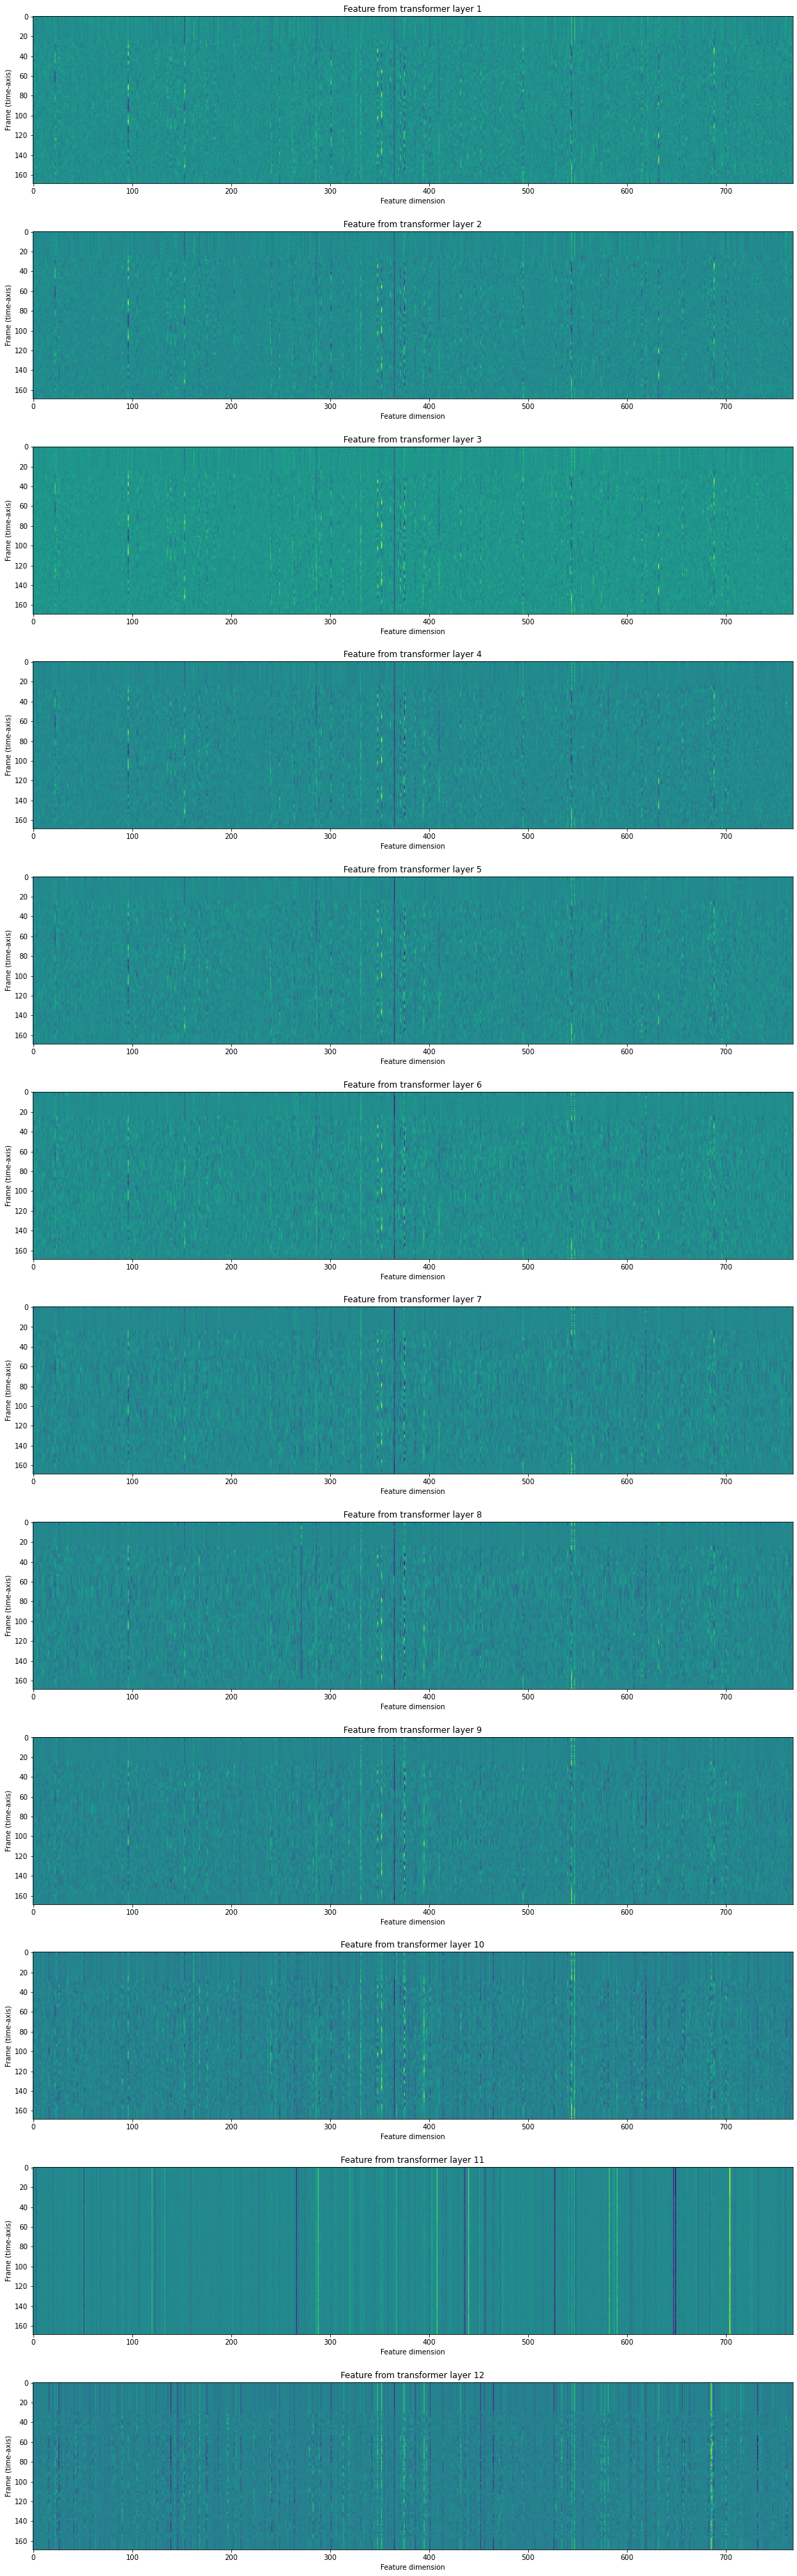

In [9]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

# Feature Classification 
classify the features in a set of categories 

In [10]:
with torch.inference_mode():
    emission, _ = model(waveform)

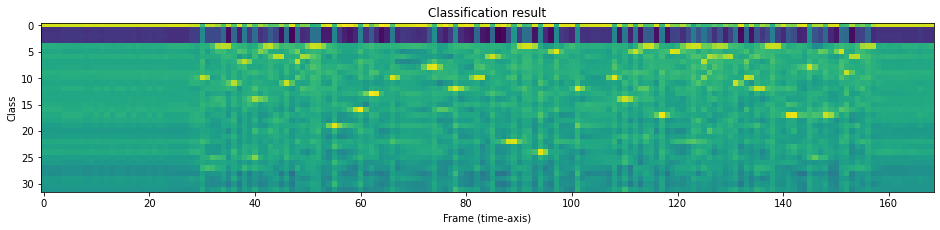

Class labels: ('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [11]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

Greedy Decoding Algorithm

In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, ignore):
        super().__init__()
        self.labels = labels
        self.ignore = ignore 

        def forward(self, emission: torch.Tensor) -> str:
            """Given a sequence emission over labels, get the best path string

            Args:
                emission (torch.Tensor): Logit tensor. Shape '[num_seq, num_label]'.
            

            Returns:
                str: The resulting transcript
            """
            indices = torch.argmax(emission, dim=-1) # [num_seq,]
            indices = torch.unique_consecutive(indicies, dim=-1)
            indices = [i for i in indicies if i not in self.ignore]
            return ''.join([self.labels[i] for i in indices])

In [14]:
decoder = GreedyCTCDecoder(
    labels=bundle.get_labels(), 
    ignore=(0, 1, 2, 3), 
)
transcript = decoder(emission[0])

NotImplementedError: 